In [67]:
from get_dataset import * 
import numpy as np
from tensorflow.keras import models, layers
import os
import json
import copy
import statistics 
import matplotlib.pyplot as plt
import seaborn as sns

BACH_SIZE = 64
MODELS_FOLDER = "saved_models"

if not os.path.exists(MODELS_FOLDER):
    os.mkdir(MODELS_FOLDER)

ds_train = get_dataset("train")
ds_test = get_dataset("test")

def my_map(x, y):
    return x[..., tf.newaxis], y

ds_train_conv = ds_train.map(my_map)
ds_test_conv = ds_test.map(my_map)

def get_models():
    conv_model = models.Sequential([
        layers.Input(shape=[124, 129, 1]),
        layers.Resizing(32, 64),
        layers.Conv2D(32, 3, activation='gelu'),
        layers.Conv2D(32, 4, activation='gelu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='gelu'),
        layers.Dropout(0.5),
        layers.Dense(12),
    ])

    rnn_model = models.Sequential([
        layers.Input(shape=[124, 129]),
        layers.Bidirectional(layers.SimpleRNN(64)),
        layers.Dense(12)
    ])

    lstm_model = models.Sequential([
        layers.Input(shape=[124, 129]),
        layers.Bidirectional(layers.LSTM(128)),
        layers.Dense(12)
    ])

    gru_model = models.Sequential([
        layers.Input(shape=[124, 129]),
        layers.Bidirectional(layers.GRU(128)),
        layers.Dense(12)
    ])

    models_dict = [
        {
            "model": conv_model,
            "datasets": (ds_train_conv, ds_test_conv),
            "name": "conv"
        },
        {
            "model": rnn_model,
            "datasets": (ds_train, ds_test),
            "name": "rnn"
        },
        {
            "model": lstm_model,
            "datasets": (ds_train, ds_test),
            "name": "lstm"
        },
        {
            "model": gru_model,
            "datasets": (ds_train, ds_test),
            "name": "gru"
        },
    ]
    return models_dict

In [2]:
models_dict = get_models()

2023-04-20 18:30:56.199419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 18:30:56.200481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 18:30:56.201314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [3]:
f = open(MODELS_FOLDER+"/history.json", "r")
history = json.load(f)
f.close()

In [14]:
max_history = {}
for iter, hmd in history.items():
    max_history[iter] = {}
    for name, metr in hmd.items():
        max_history[iter][name] = {}
        d = {}
        idx = max(range(len(metr["val_accuracy"])), key=metr["val_accuracy"].__getitem__)
        d["epoch_count"] = idx
        d["loss"] = metr["loss"][idx]
        d["accuracy"] = metr["accuracy"][idx]
        d["val_loss"] = metr["val_loss"][idx]
        d["val_accuracy"] = metr["val_accuracy"][idx]
        max_history[iter][name] = d

In [28]:
ITER = 15
stat_history = {}
for name, metr in max_history["0"].items():
    stat_history[name] = {}
    for mn, _ in metr.items():
        stat_history[name][mn] = {}
        stat_history[name][mn]["mean"] = round(statistics.mean([max_history[str(x)][name][mn] for x in range(ITER)]), 3)
        stat_history[name][mn]["std"] = round(statistics.stdev([max_history[str(x)][name][mn] for x in range(ITER)]), 3)

In [29]:
stat_history

{'conv': {'epoch_count': {'mean': 8.267, 'std': 2.404},
  'loss': {'mean': 0.333, 'std': 0.067},
  'accuracy': {'mean': 0.887, 'std': 0.022},
  'val_loss': {'mean': 0.558, 'std': 0.029},
  'val_accuracy': {'mean': 0.841, 'std': 0.008}},
 'rnn': {'epoch_count': {'mean': 2.067, 'std': 1.438},
  'loss': {'mean': 2.094, 'std': 0.044},
  'accuracy': {'mean': 0.265, 'std': 0.022},
  'val_loss': {'mean': 2.23, 'std': 0.07},
  'val_accuracy': {'mean': 0.229, 'std': 0.021}},
 'lstm': {'epoch_count': {'mean': 12.867, 'std': 3.399},
  'loss': {'mean': 0.226, 'std': 0.045},
  'accuracy': {'mean': 0.927, 'std': 0.014},
  'val_loss': {'mean': 0.466, 'std': 0.035},
  'val_accuracy': {'mean': 0.862, 'std': 0.01}},
 'gru': {'epoch_count': {'mean': 8.867, 'std': 2.066},
  'loss': {'mean': 0.165, 'std': 0.035},
  'accuracy': {'mean': 0.947, 'std': 0.011},
  'val_loss': {'mean': 0.421, 'std': 0.028},
  'val_accuracy': {'mean': 0.88, 'std': 0.009}}}

In [52]:
cats = get_categories()
cats

{0: 'yes',
 1: 'no',
 2: 'up',
 3: 'down',
 4: 'left',
 5: 'right',
 6: 'on',
 7: 'off',
 8: 'stop',
 9: 'go',
 10: 'other',
 11: 'silence'}

In [53]:
cats = list(cats.values())
cats

['yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go',
 'other',
 'silence']

In [78]:
def print_confution_matrix(model_item):
    model_name = model_item["name"]
    model = model_item["model"]
    _, test = model_item["datasets"]
    test = test.batch(64)
    vas = list([max_history[str(i)][model_name]["val_accuracy"] for i in range(ITER)])
    idx = max(range(ITER), key=vas.__getitem__)
    model.load_weights(MODELS_FOLDER+"/"+model_name+"_"+str(idx))
    y_pred = model.predict(test)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test.map(lambda s,lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=cats,
                yticklabels=cats,
                annot=True, fmt='g', cbar=False)
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title(model_name)
    plt.show()


49/49 [==============================] - 0s 2ms/step


2023-04-20 20:36:45.045486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 20:36:45.178666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


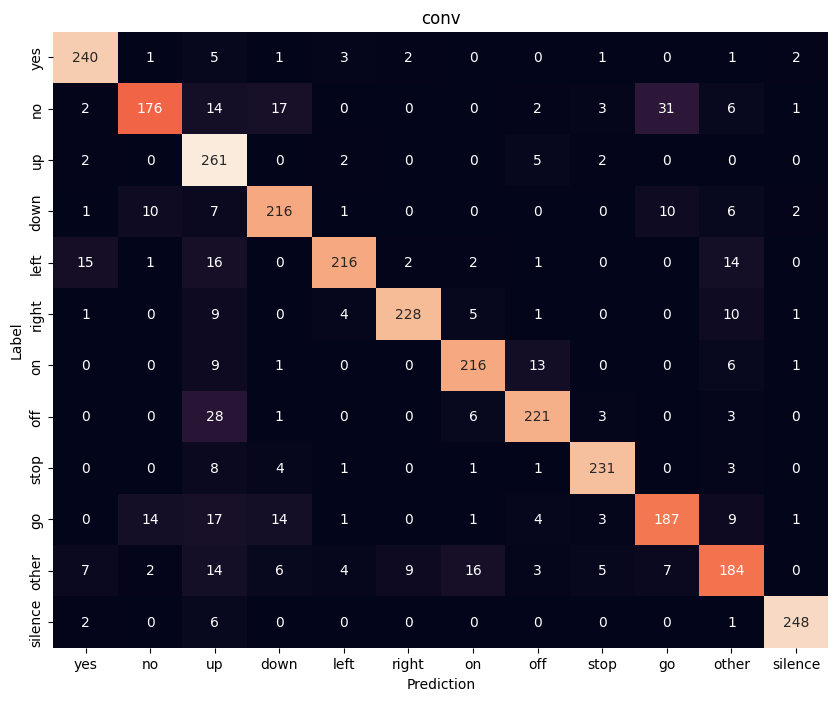

In [79]:
print_confution_matrix(models_dict[0])

      1/Unknown - 0s 158ms/step

2023-04-20 20:37:05.912419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/49 [==============================] - 1s 16ms/step


2023-04-20 20:37:06.846076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


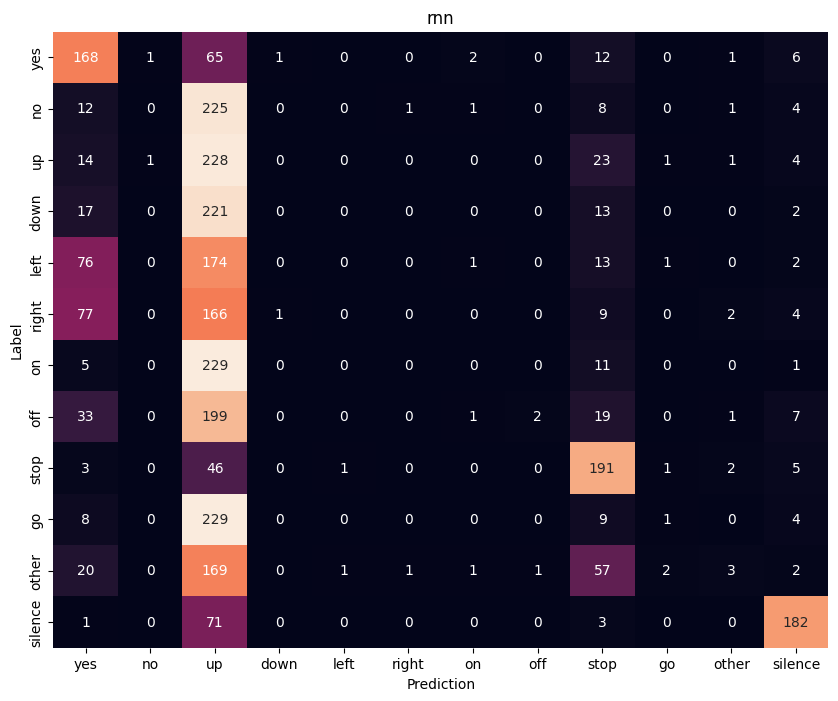

In [80]:
print_confution_matrix(models_dict[1])

2023-04-20 20:37:15.570063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 20:37:15.699443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 20:37:15.700342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

49/49 [==============================] - 1s 5ms/step


2023-04-20 20:37:16.389443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


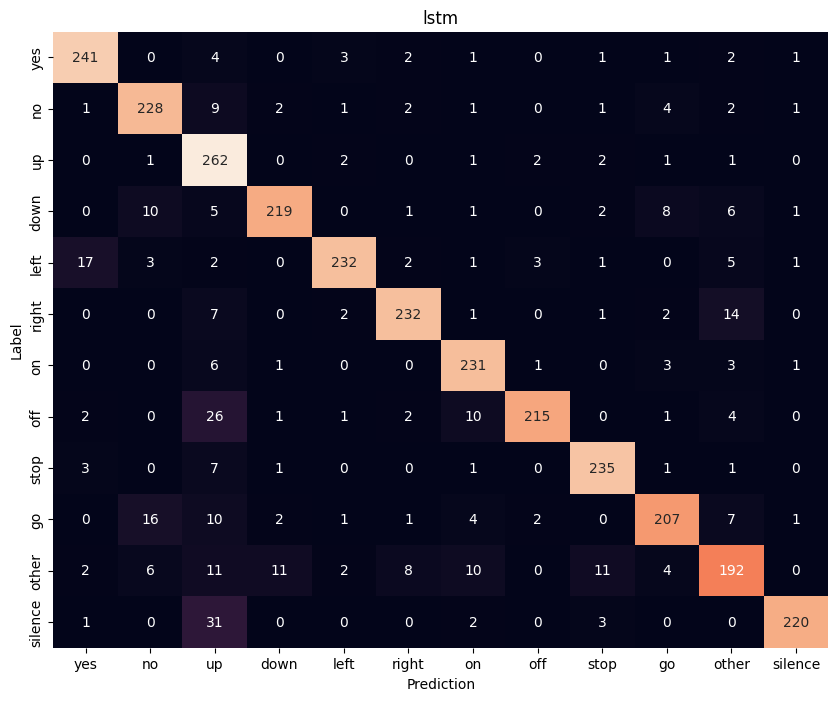

In [81]:
print_confution_matrix(models_dict[2])

2023-04-20 20:37:26.460534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 20:37:26.571680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 20:37:26.572458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

     22/Unknown - 0s 5ms/step 

2023-04-20 20:37:26.684903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 20:37:26.686044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 20:37:26.686802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/49 [==============================] - 1s 5ms/step


2023-04-20 20:37:27.048802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


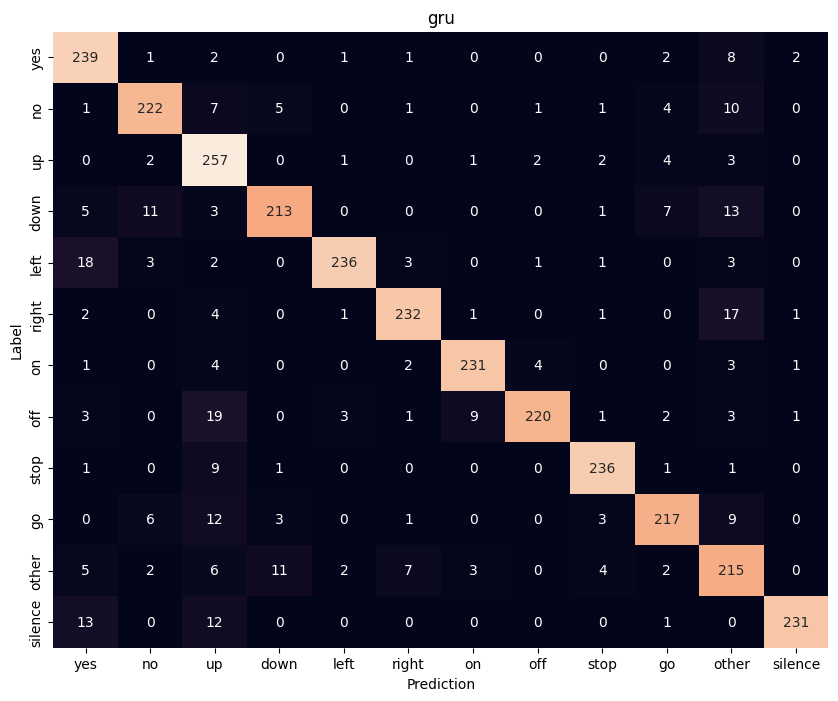

In [82]:
print_confution_matrix(models_dict[3])